# TP 1 - Hidden Markov Models implementation

## Imports

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import itertools

## HMM Class

In [72]:
class HMM:
    def __init__(self,  nu,  Q,  theta):
        self.Q = Q
        self.nu = nu
        self.theta = theta
        self.N = len(nu)

    def forward(self,  data):
        return HMM.forward_(self.nu,  self.Q,  self.theta,  data)

    def calibrate(self,data, x0):
        def objective(params):
            nu = params[:self.N]
            Q_flat = params[self.N:self.N + self.N * self.N]
            Q = [Q_flat[self.N*k:self.N*(k+1)] for k in range(0,self.N)]
            theta = params[self.N + self.N * self.N:]
            _,llh,_ = HMM.forward_scaled(nu,Q,theta,data)
            return -llh
        Aeq = np.kron(np.eye(self.N+1),np.ones((1,self.N)))
        shp = (self.N + 1, 2 * self.N)
        Aeq = np.concatenate([Aeq, np.zeros(shp)],axis = 1)
        beq = np.ones((self.N+1))
        cons = [{"type": "eq", "fun": lambda x: (Aeq @ x).T - beq}]
        bnds = [(0, 1)] * (self.N + self.N**2) + [(None,None),(0,None)]*self.N
        res = sp.optimize.minimize(objective, x0, method='SLSQP', bounds = bnds, constraints = cons)
        nu_res = res.x[:self.N]
        Q_res_flat = res.x[self.N:self.N + self.N * self.N]
        Q_res = [Q_res_flat[self.N*k:self.N*(k+1)] for k in range(0,self.N)]
        theta_res = res.x[self.N + self.N * self.N:]
        self.nu = nu_res
        self.Q = Q_res
        self.theta = theta_res
        return self
    
    @staticmethod
    def forward_scaled(nu,  Q,  theta,  data):
        T = len(data)
        N = np.shape(Q)[0]
        B = np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data) for k in range(0,N)]).T
        B[B < 1e-7] = 1e-7
        alpha = np.zeros((T, N))
        ascale = np.zeros((T, 1))
        alpha[0,:] =  B[0,:] @ nu
        ascale[0] = 1.0 / np.sum(alpha[0,:])
        for i in range(1, T):
            predicted = alpha[i-1,:] @ Q
            alpha[i,:] = predicted * B[i,:]
            ascale[i] = 1.0 /np.sum(alpha[i,:])
            alpha[i,:] *= ascale[i]
        llh = -np.sum(np.log(ascale))
        return alpha, llh, ascale

    def compute_llh( nu, Q, theta, data):
        _, llh, x = HMM.forward_scaled(nu, Q, theta, data)
        return llh

    def forward_backward(nu, Q, theta, data):
        T = len(data)
        N = np.shape(Q)[0]
        (alpha, llh, ascale) = HMM.forward_scaled(nu, Q, theta, data)
        B = np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data) for k in range(0,N)]).T
        B[B < 1e-7] = 1e-7
        beta = np.zeros((T, N))
        gamma = np.zeros((T, N))
        ksi = np.zeros((T-1, N))
        beta[-1, :] = 1
        beta[-1, :] *= ascale[-1]
        gamma[-1,:] = beta[-1,:] * alpha[-1,:] / np.sum(beta[-1,:] * alpha[-1,:], axis = 0)
        for i in range(T-2, -1, -1):
            beta[i, :] = (B[i+1,:] * beta[i+1, :]) @ np.asarray(Q).T
            beta[i, :] *= ascale[i]
            gamma[i,:] = (alpha[i,:] *  beta[i,:])/np.sum(beta[i,:] @ alpha[i,:])
        return alpha, beta, gamma, llh

    def simulate(nu, Q, theta, M):
        N = np.shape(Q)[0]
        sample = np.zeros((M, 2))
        X_traj = np.zeros((M, ), dtype=int)
        X_traj[0] = np.random.choice(range(0, N), size=(1, ), replace = True, p = nu)[0]
        for i in range(1, M):
            prev = X_traj[i-1]
            X_traj[i] = np.random.choice(range(0, N), size=(1, ), replace = True, p = Q[prev, :])[0]
        sample[:, 1] = X_traj
        for k in range(0, N):
            M_k = sample[sample[:, 1] == k].shape[0]
            sample[sample[:, 1] == k, 0] = np.random.normal(theta[2*k], theta[2*k+1], M_k)
        return sample[:, 0], X_traj

    def decode_gamma(nu, Q, theta, data):
        _, _, gamma, _ = HMM.forward_backward(nu, Q, theta, data)
        xhat = np.argmax(gamma,axis=1)
        return xhat

    def decode_viterbi(nu, Q, theta, data):
        T = len(data)
        N = np.shape(Q)[0]
        delta = np.zeros((T, N))
        psi = np.zeros((T, N),dtype=int)
        xhat = np.zeros((T, 1), dtype=int)
        log_nu = np.where(np.asarray(nu) > 0, np.log(nu), -np.inf)
        log_Q = np.where(np.asarray(Q) > 0, np.log(Q), -np.inf)
        delta[0, :] = log_nu + np.log(np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data[0]) for k in range(0,N)]).T)
        for t in range(1, T):
            scores = delta[t-1][:, None] + log_Q
            psi[t, :] = np.argmax(scores, axis=0)
            max_scores = np.max(scores, axis=0)
            delta[t, :] = max_scores + log_nu + np.log(np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data[t]) for k in range(0,N)]).T)
        xhat[-1] = np.argmax(delta[-1, :])
        for t in range(T - 2, -1, -1):
            xhat[t] = psi[t + 1, xhat[t + 1]]
        logp = delta[-1, xhat[-1]]
        return xhat.flatten()

## Simulate some mixed data

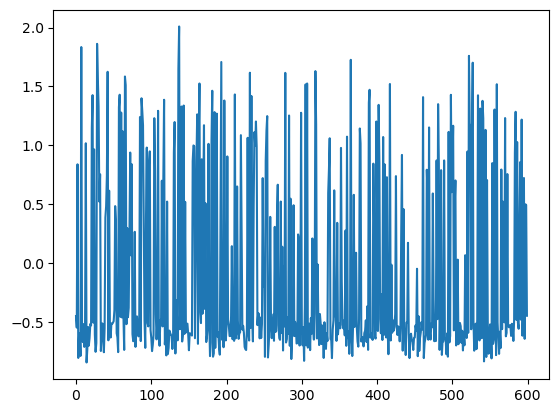

In [3]:
Y1 = np.random.normal(-0.6,0.1,400)
Y2 = np.random.normal(0.9,0.5,200)
Y = np.concatenate([Y1,Y2])
np.random.shuffle(Y)
plt.plot(Y)

## Check the forward-backward algorithm, gamma-decoding and viterbi decoding

In [4]:
nu = [0.5, 0.5]
Q = [[0.9, 0.1], [0.8, 0.2]]
theta = [0, 0.3, 0, 0.5]

In [5]:
HMM.forward_scaled(nu,Q,theta,Y)

(array([[0.47956195, 0.47956195],
        [0.76327799, 0.23672201],
        [0.49288777, 0.50711223],
        ...,
        [0.82355057, 0.17644943],
        [0.8406158 , 0.1593842 ],
        [0.86114346, 0.13885654]]),
 -1326.1247433231274,
 array([[1.04261817e+00],
        [3.77458797e+00],
        [2.09401139e+01],
        [1.59492446e+01],
        [5.33521746e+00],
        [4.73339834e+00],
        [1.55223495e+01],
        [7.30802747e+03],
        [5.16038106e+00],
        [7.29568867e+00],
        [3.14077038e+00],
        [9.66394284e+00],
        [3.96197029e+00],
        [6.22578427e+01],
        [1.84656659e+01],
        [1.00162166e+01],
        [3.54017900e+00],
        [8.99610538e+00],
        [5.98621569e+00],
        [3.12833540e+00],
        [3.36178636e+00],
        [1.31695416e+02],
        [3.84129720e+02],
        [2.86163387e+00],
        [4.48105000e+01],
        [4.84150799e+00],
        [1.22172739e+01],
        [7.64373183e+00],
        [9.59161426e+03],
     

In [6]:
HMM.forward_backward(nu, Q, theta, Y)

(array([[0.47956195, 0.47956195],
        [0.76327799, 0.23672201],
        [0.49288777, 0.50711223],
        ...,
        [0.82355057, 0.17644943],
        [0.8406158 , 0.1593842 ],
        [0.86114346, 0.13885654]]),
 array([[ 1.01721631,  1.15688897],
        [ 3.3933128 ,  5.00395797],
        [17.58322017, 24.20284689],
        ...,
        [ 2.79831518,  2.91983385],
        [ 2.74908166,  2.8107706 ],
        [ 2.24735117,  2.24735117]]),
 array([[0.46787813, 0.53212187],
        [0.68617846, 0.31382154],
        [0.4138733 , 0.5861267 ],
        ...,
        [0.81728815, 0.18271185],
        [0.83762001, 0.16237999],
        [0.86114346, 0.13885654]]),
 -1326.1247433231274)

In [7]:
_, _, gamma, _= HMM.forward_backward(nu, Q, theta, Y)
gamma

array([[0.46787813, 0.53212187],
       [0.68617846, 0.31382154],
       [0.4138733 , 0.5861267 ],
       ...,
       [0.81728815, 0.18271185],
       [0.83762001, 0.16237999],
       [0.86114346, 0.13885654]])

## Fit the model to the data

In [8]:
x0 = [0.5, 0.5,0.8,0.2,0.1,0.9,-0.2,0.3,-1,1]
H = HMM(nu, Q, theta)
H.calibrate(Y,x0)

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [9]:
print(H.nu)
print(H.Q)
print(H.theta)

[1. 0.]
[array([0.67479406, 0.32520594]), array([0.64182499, 0.35817501])]
[-0.60478259  0.10243684  0.86971529  0.49474809]


Use fitted model to classify the data

In [ ]:
gloc = HMM.decode_gamma(H.nu,H.Q,H.theta,Y)

In [11]:
gloc

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,

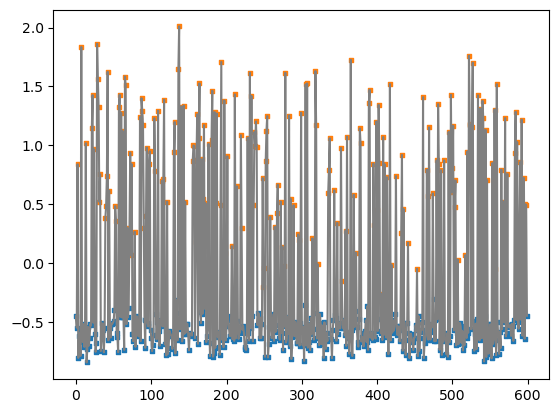

In [12]:
def plot_by_state(data,classes):    
    plt.plot(range(0,len(data)),data,color='grey')
    plt.scatter(np.where(classes==0),data[classes==0],marker = 's',s=10)
    plt.scatter(np.where(classes==1),data[classes==1],marker ='s',s=10)
    return
plot_by_state(Y,gloc)

In [13]:
gvit = HMM.decode_viterbi(H.nu,H.Q,H.theta,Y)

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_5231/3565989984.py:100: RuntimeWarning: divide by zero encountered in log
  log_nu = np.where(np.asarray(nu) > 0, np.log(nu), -np.inf)


In [14]:
gvit

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

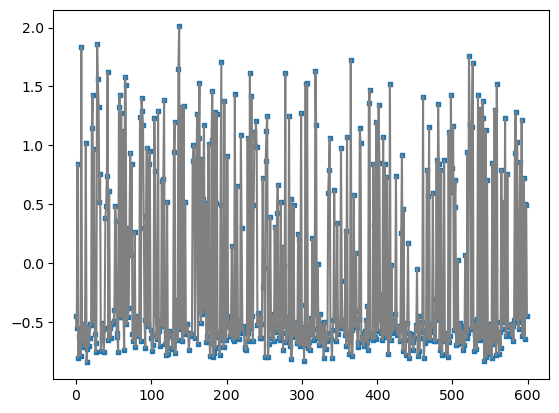

In [15]:
plot_by_state(Y,gvit)

## Data from YFinance

In [16]:
import yfinance as yf
import pandas as pd

In [17]:
df = yf.download("^FCHI",period="5y", interval="1d", progress=False)

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_5231/1345964138.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^FCHI",period="5y", interval="1d", progress=False)


In [18]:
df

Price,Close,High,Low,Open,Volume
Ticker,^FCHI,^FCHI,^FCHI,^FCHI,^FCHI
Date,,,,,
2021-01-28,5510.520020,5525.950195,5379.220215,5407.740234,113180800
2021-01-29,5399.209961,5474.799805,5399.209961,5421.529785,109393800
2021-02-01,5461.680176,5481.669922,5429.779785,5441.430176,75051100
2021-02-02,5563.109863,5574.770020,5509.240234,5510.620117,92321700
2021-02-03,5563.049805,5626.410156,5554.089844,5610.589844,81321400
...,...,...,...,...,...
2026-01-22,8148.890137,8190.080078,8142.439941,8163.560059,63848100
2026-01-23,8143.049805,8156.049805,8095.000000,8116.810059,51901000


In [19]:
adj = df['Close']
adj

Ticker,^FCHI
Date,
2021-01-28,5510.520020
2021-01-29,5399.209961
2021-02-01,5461.680176
2021-02-02,5563.109863
2021-02-03,5563.049805
...,...
2026-01-22,8148.890137
2026-01-23,8143.049805
2026-01-26,8131.149902


<Axes: xlabel='Date'>

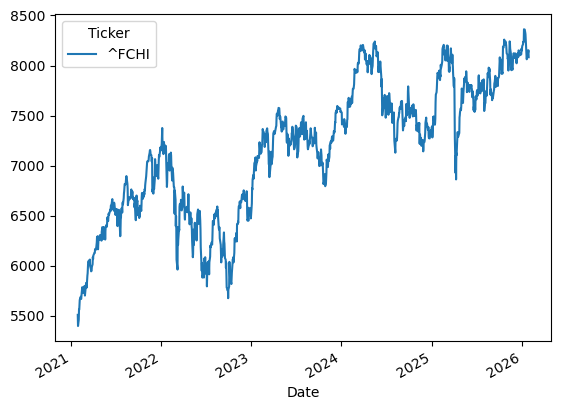

In [20]:
adj.plot()

In [21]:
daily_returns = adj.pct_change().dropna()

<Axes: xlabel='Date'>

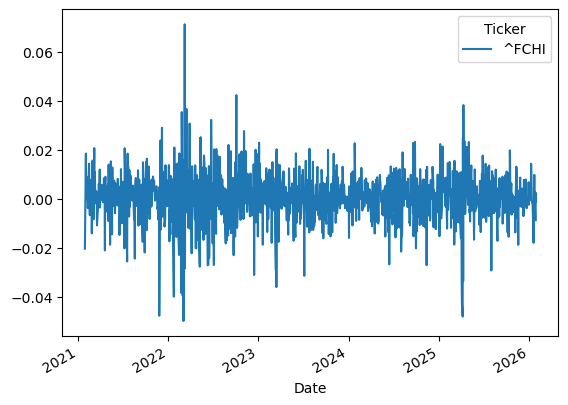

In [22]:
daily_returns.plot()

In [23]:
print(daily_returns.shape)

(1281, 1)


In [48]:
x0 = [0.5, 0.5, 0.9, 0.1, 0.8, 0.2, 0.2, 0.3, 1,0.3]

In [49]:
model = HMM(nu ,Q, theta)

In [50]:
model.calibrate(daily_returns.values.ravel(), x0)

In [ ]:
Q = model.Q

[array([0.99802235, 0.00197765]), array([0.2711409, 0.7288591])]

In [ ]:
nu = model.nu

array([9.99997258e-01, 2.74159971e-06])

In [ ]:
N = model.N

2

In [67]:
data  = daily_returns.values.squeeze()

In [68]:
data

array([-0.02019956,  0.01157025,  0.01857115, ..., -0.00146136,
        0.00266505, -0.00855287])

In [79]:
gloc = HMM.decode_gamma(model.nu, model.Q, model.theta, data)

In [80]:
gloc

array([0, 0, 0, ..., 0, 0, 0])